## Analyze whether early or late snow changes more year to year or place to place.

* We know from previous notebooks that the value of `coef_2` corresponds to whether the snow season is early or late. 
* We want to study whether early/late season is more dependent on the year or on the location.
* We will use RMS Error to quantify the strength of these dependencies.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
%pylab inline
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [28]:
### Read the data frame from pickle file

data_dir='../Data/Weather'
state='WA'
meas='TOBS_s20'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [29]:
#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())


12636


In [30]:
tmp=df.filter(df.Year=='1980').toPandas()
tmp.head(1)

,Measurement,Station,Values,Year,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,dist_coast,...,latitude,longitude,name,res_1,res_2,res_3,res_4,res_5,res_mean,total_var
0,TOBS_s20,USC00454486,"[136, 77, 87, 77, 39, 77, 247, 76, 199, 76, 15...",1980,557.496711,-358.053608,42.862688,106.164237,27.565953,24.2022,...,47.376701,-121.961403,LANDSBURG,0.321313,0.041363,0.037351,0.012739,0.01108,0.172691,2.651833e+06


In [68]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


,station,year,coeff_2
0,USC00454486,1924,-36.340063
1,USC00454486,1925,-506.527762
2,USC00454486,1926,-394.974859
3,USC00454486,1927,-232.014465
4,USC00454486,1928,-393.061378


In [69]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.head(5)

station,USC00450008,USC00450013,USC00450094,USC00450158,USC00450176,USC00450184,USC00450217,USC00450257,USC00450456,USC00450482,...,USW00024219,USW00024237,USW00024239,USW00024240,USW00024243,USW00024244,USW00094103,USW00094197,USW00094227,USW00094290
year,,,,,,,,,,,,,,,,,,,,,
1890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901,-408.400663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0,0.5,'Number of stations')

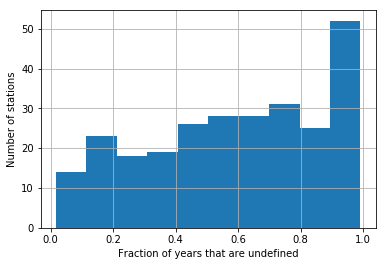

In [55]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0,0.5,'fraction of stations that are undefined')

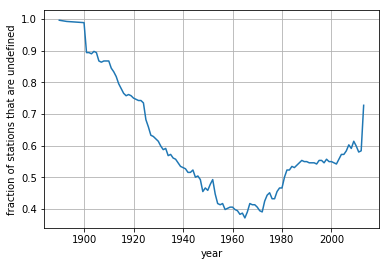

In [56]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [70]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station,USC00450008,USC00450013,USC00450158,USC00450176,USC00450184,USC00450217,USC00450257,USC00450456,USC00450482,USC00450564,...,USC00459342,USC00459376,USC00459455,USC00459463,USW00024141,USW00024219,USW00024239,USW00094197,USW00094227,USW00094290
year,,,,,,,,,,,,,,,,,,,,,
2009,-313.621377,NaN,NaN,-377.671774,NaN,NaN,NaN,-56.144153,NaN,NaN,...,NaN,612.324708,447.364296,NaN,NaN,NaN,NaN,520.592791,NaN,NaN
2010,-561.142547,NaN,NaN,-666.752819,NaN,46.429713,NaN,-296.607344,NaN,NaN,...,NaN,265.416489,199.722275,NaN,NaN,NaN,NaN,264.544616,NaN,NaN
2011,-418.323539,NaN,NaN,-467.098583,NaN,NaN,-234.218647,-137.215591,NaN,NaN,...,NaN,471.527433,292.646367,NaN,NaN,NaN,NaN,51.673866,NaN,NaN
2012,-502.429946,NaN,NaN,-454.611990,NaN,NaN,-280.022369,-151.809660,NaN,NaN,...,NaN,466.198585,289.852255,NaN,NaN,NaN,NaN,NaN,NaN,-153.472456
2013,-70.366298,NaN,NaN,NaN,NaN,NaN,76.496942,90.177152,NaN,NaN,...,NaN,374.798912,188.589188,NaN,NaN,NaN,NaN,NaN,NaN,-187.800191


Text(0,0.5,'Number of stations')

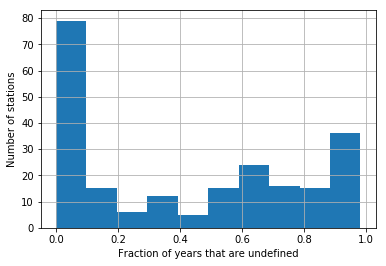

In [59]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [71]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  347.9303001503575
RMS removing mean-by-station=  123.71386591664832 reduction= 224.21643423370915
RMS removing mean-by-year   =  336.4093813076728 reduction= 11.520918842684694


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* We can use **alternating minimization** to remove the combined effect of location and time.

In [65]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 672.0107306222479
0 after removing mean by year    = 655.0461207687267
0 after removing mean by stations= 340.9757451331049
1 after removing mean by year    = 340.25928088352936
1 after removing mean by stations= 340.19617341471644
2 after removing mean by year    = 340.1857965091708
2 after removing mean by stations= 340.18354374991776
3 after removing mean by year    = 340.18300281016485
3 after removing mean by stations= 340.18286888593167
4 after removing mean by year    = 340.1828354392231
4 after removing mean by stations= 340.18282706562456


In [66]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1961    0.278621
1962    0.254761
1963    0.248498
1964    0.236219
1965    0.220411
Name: mean_by_year, dtype: float64

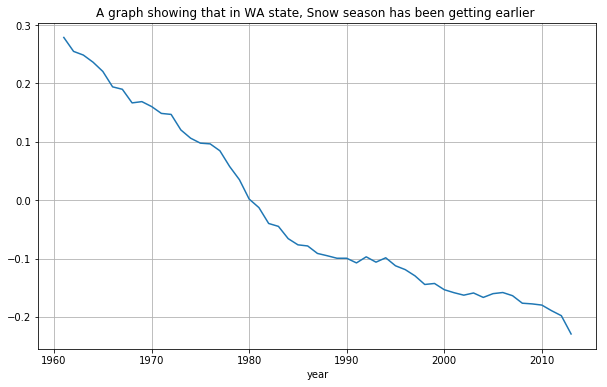

In [67]:
figure(figsize=(10,6))
T['mean_by_year'].plot();
grid()
title('A graph showing that in WA state, Snow season has been getting earlier ');

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY has been getting earlier and earlier since 1960.